In [1]:
# from torchsummary import summary
# from torchviz import make_dot
import albumentations as A
import mlflow
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms as TF
import tqdm
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import PolynomialLR

from DiceBCELoss import DiceBCELoss
from model import UNetPlusPlus, ResNeXtBottleneck
from utils import *

In [2]:
EXPERIMENT_NAME = "CS679_Project"

In [3]:
# experiment_id = mlflow.create_experiment(f"{EXPERIMENT_NAME}")
experiment = mlflow.get_experiment_by_name(f"{EXPERIMENT_NAME}")
mlflow.set_experiment(f"{EXPERIMENT_NAME}")

<Experiment: artifact_location='file:///mnt/hpc/work/m43huang/project_Kamurocho/mlruns/409732428176556896', creation_time=1744347925664, experiment_id='409732428176556896', last_update_time=1744347925664, lifecycle_stage='active', name='CS679_Project', tags={}>

In [4]:
lr = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 12
epochs = 300
pin_memory = True

# Data

Path: \
stenosis_train = ARCADE('dataset/stenosis/train')\
syntax__test = ARCADE('dataset/syntax_/test')\
syntax__val = ARCADE('dataset/stenosis/val')\
syntax_train = ARCADE('dataset/syntax/train')\
syntax_test = ARCADE('dataset/syntax/test')\
syntax_val = ARCADE('dataset/syntax/val')

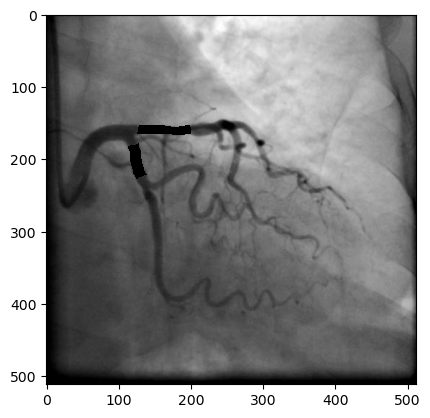

In [5]:
sample = ARCADE('dataset/stenosis/train')[10]
image = sample[0].reshape((512, 512))
mask = sample[1].reshape((512, 512))

plot_image_with_mask(image, mask)

In [6]:
image.shape

(512, 512)

In [7]:
mask.shape

(512, 512)

In [8]:
train_transform = A.Compose([
    A.VerticalFlip(p=0.5),  
    A.HorizontalFlip(p=0.5),  
    # A.ShiftScaleRotate(
    #     shift_limit=0.3,  
    #     scale_limit=0.5,  
    #     rotate_limit=30, 
    #     p=1.0 
    # ),
    A.Affine(translate_percent=(-0.3,0.3),scale=(0.5,1.5),rotate=(-30,30),shear=5, p=1.0, border_mode=2),  
    A.Perspective(scale=(0.001, 0.001), p=1.0),
    A.Illumination(intensity_range=(0.01,0.05)),
     ToTensorV2()
])
val_transform = A.Compose([
    ToTensorV2()  # This ensures the output is in the format PyTorch expects
])

# stenosis_train, stenosis_test, stenosis_val = get_loaders('dataset/stenosis/train', 'dataset/stenosis/test',
#                                                           'dataset/stenosis/val', batch_size, train_transform,
#                                                           val_transform, val_transform)

syntax_train, syntax_test, syntax_val = get_loaders('dataset/syntax/train', 'dataset/syntax/test', 'dataset/syntax/val', batch_size, train_transform,
                                                          val_transform, val_transform)

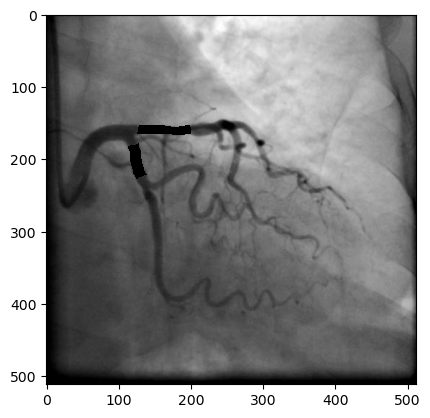

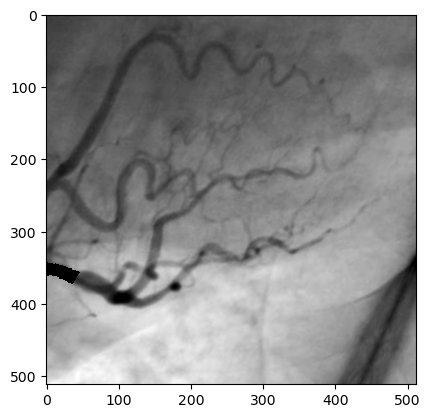

In [9]:
sample = ARCADE('dataset/stenosis/train')[10]
image = sample[0].reshape((512, 512))
mask = sample[1].reshape((512, 512))

plot_image_with_mask(image, mask)
aug=train_transform(image=image,mask=mask)
plot_image_with_mask(aug["image"].squeeze(0), aug["mask"].squeeze(0))

# Model

In [10]:
# model = UNetPlusPlus()
# summary(model, (1, 512, 512))

In [11]:
# os.environ["PATH"] += os.pathsep + 'F:/Program Files/Graphviz/bin/'
# x = torch.randn(1, 1, 512, 512)
# y = model(x)
# make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render("rnn_torchviz", format="png")

# Training

In [12]:
model = torch.compile(UNetPlusPlus(block=ResNeXtBottleneck).to(device))

In [13]:
criterion = DiceBCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-5)

scaler = torch.amp.GradScaler()

best_f1, best_iou, best_dsc = 0.0, 0.0, 0.0

# mlflow.start_run()
# mlflow.log_param("learning_rate", lr)
# mlflow.log_param("epochs", epochs)
# mlflow.log_param("batch_size", batch_size)
# mlflow.log_param("optimizer", "Adam")
# mlflow.log_param("scheduler", "GradScaler")

for epoch in tqdm.trange(epochs):
    # loop = tqdm.tqdm(stenosis_train, leave=True, position=0)
    # for batch_idx, (data, targets) in enumerate(loop):
    for batch_idx, (data, targets) in enumerate(syntax_train):
        data = data.to(device=device)
        targets = targets.float().to(device=device)

        # forward
        predictions = model(data)
        loss = criterion(predictions, targets)
        # mlflow.log_metric("Loss", loss.item(), step=epoch * batch_size + batch_idx + 1)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    avg_f1, avg_iou, avg_dsc = track_metric(syntax_val, model, device=device)
    scheduler.step()
    
    # mlflow.log_metric("Avg F1", avg_f1, step=epoch)
    # mlflow.log_metric("Avg IoU", avg_iou, step=epoch)
    # mlflow.log_metric("Avg DSC", avg_dsc, step=epoch)

    
    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_iou = avg_iou
        best_dsc = avg_dsc
        print(f"Best F1: {best_f1}, Best IoU: {best_iou}, Best DSC: {best_dsc}")
        torch.save(model, "./checkpoint/best.pth".format(epoch))
        # mlflow.log_artifact("./checkpoint/best.pth".format(epoch))
    else:
        print(f"F1: {avg_f1}, IoU: {avg_iou}, DSC: {avg_dsc}")
        torch.save(model, "./checkpoint/last.pth".format(epoch))
        # mlflow.log_artifact("./checkpoint/last.pth".format(epoch))
# mlflow.end_run()

  0%|          | 1/300 [01:31<7:38:01, 91.91s/it]

Best F1: 0.4871103911901111, Best IoU: 0.32259906513980974, Best DSC: 0.4871103911902481


  1%|          | 2/300 [02:31<6:00:46, 72.64s/it]

Best F1: 0.5656613122654397, Best IoU: 0.3950387687269441, Best DSC: 0.5656613122656672


  1%|          | 3/300 [03:29<5:28:26, 66.35s/it]

Best F1: 0.6747603483727831, Best IoU: 0.5103274729529984, Best DSC: 0.6747603483729177


  1%|▏         | 4/300 [04:28<5:12:55, 63.43s/it]

F1: 0.6648092938113384, IoU: 0.4990820612540454, DSC: 0.6648092938114765


  2%|▏         | 5/300 [05:27<5:03:58, 61.82s/it]

F1: 0.6675184656683731, IoU: 0.5021148271316043, DSC: 0.6675184656685001


  2%|▏         | 6/300 [06:26<4:58:04, 60.83s/it]

Best F1: 0.7003560960698961, Best IoU: 0.539992694999288, Best DSC: 0.700356096070023


  2%|▏         | 7/300 [07:25<4:54:05, 60.22s/it]

Best F1: 0.7004437722174288, Best IoU: 0.5400509876398701, Best DSC: 0.7004437722175547


  3%|▎         | 8/300 [08:24<4:51:01, 59.80s/it]

F1: 0.6944982851506446, IoU: 0.5330949290899718, DSC: 0.6944982851507645


  3%|▎         | 9/300 [09:23<4:48:34, 59.50s/it]

Best F1: 0.7044588695569305, Best IoU: 0.5448599209313242, Best DSC: 0.7044588695570492
Best F1: 0.7077951801569212, Best IoU: 0.5488094384078269, Best DSC: 0.7077951801570399


  4%|▎         | 11/300 [11:21<4:45:33, 59.29s/it]

F1: 0.6841356427440861, IoU: 0.5208674443120462, DSC: 0.684135642744229


  4%|▍         | 12/300 [12:20<4:43:36, 59.09s/it]

F1: 0.6939566142283714, IoU: 0.5323853106648821, DSC: 0.6939566142284898


  4%|▍         | 13/300 [13:19<4:41:58, 58.95s/it]

F1: 0.6981253522633545, IoU: 0.5371170862328917, DSC: 0.6981253522634733


  5%|▍         | 14/300 [14:17<4:40:27, 58.84s/it]

F1: 0.7053781027268985, IoU: 0.54577413227581, DSC: 0.7053781027270147


  5%|▌         | 15/300 [15:16<4:39:11, 58.78s/it]

F1: 0.7037491433358324, IoU: 0.544019752197896, DSC: 0.7037491433359498


  5%|▌         | 16/300 [16:14<4:38:10, 58.77s/it]

F1: 0.693002134811747, IoU: 0.5312641584156563, DSC: 0.6930021348118707


  6%|▌         | 17/300 [17:13<4:37:06, 58.75s/it]

Best F1: 0.7100627042839518, Best IoU: 0.5512991993757563, Best DSC: 0.7100627042840673


  6%|▌         | 18/300 [18:12<4:36:15, 58.78s/it]

Best F1: 0.7149364037867239, Best IoU: 0.5575220969640315, Best DSC: 0.7149364037868415


  6%|▋         | 19/300 [19:11<4:34:54, 58.70s/it]

Best F1: 0.7164394907911784, Best IoU: 0.5593144980565578, Best DSC: 0.7164394907912932


  7%|▋         | 20/300 [20:09<4:33:46, 58.66s/it]

Best F1: 0.7197562017701592, Best IoU: 0.5631313685424503, Best DSC: 0.7197562017702765


  7%|▋         | 21/300 [21:08<4:33:02, 58.72s/it]

Best F1: 0.724257358961915, Best IoU: 0.5688741644801264, Best DSC: 0.7242573589620345


  7%|▋         | 22/300 [22:06<4:31:40, 58.64s/it]

F1: 0.7212380361985242, IoU: 0.5650491379431071, DSC: 0.7212380361986421


  8%|▊         | 23/300 [23:05<4:30:28, 58.59s/it]

Best F1: 0.7303058104526933, Best IoU: 0.5763010639458752, Best DSC: 0.7303058104528048


  8%|▊         | 24/300 [24:03<4:29:25, 58.57s/it]

F1: 0.7220141310173128, IoU: 0.5659234705722761, DSC: 0.7220141310174302


  8%|▊         | 25/300 [25:03<4:29:08, 58.72s/it]

F1: 0.72909223350785, IoU: 0.5748336582634855, DSC: 0.7290922335079607


  9%|▊         | 26/300 [26:02<4:28:42, 58.84s/it]

F1: 0.7238229893940566, IoU: 0.5682473907009625, DSC: 0.7238229893941694


  9%|▉         | 27/300 [27:00<4:27:23, 58.77s/it]

Best F1: 0.7325259757977232, Best IoU: 0.5790113239438027, Best DSC: 0.7325259757978335


  9%|▉         | 28/300 [27:59<4:26:15, 58.73s/it]

Best F1: 0.7328032616505041, Best IoU: 0.579396152569441, Best DSC: 0.732803261650614


 10%|▉         | 29/300 [28:57<4:25:07, 58.70s/it]

Best F1: 0.7351177778207988, Best IoU: 0.5822628384679158, Best DSC: 0.7351177778209084


 10%|█         | 30/300 [29:56<4:24:10, 58.70s/it]

Best F1: 0.7351874518764776, Best IoU: 0.5823239673712585, Best DSC: 0.7351874518765864


 10%|█         | 31/300 [30:55<4:23:26, 58.76s/it]

F1: 0.7293084320113705, IoU: 0.5750920301092867, DSC: 0.7293084320114858


 11%|█         | 32/300 [31:54<4:22:10, 58.70s/it]

F1: 0.7184840036418827, IoU: 0.5616338528116461, DSC: 0.7184840036419979


 11%|█         | 33/300 [32:52<4:21:13, 58.70s/it]

F1: 0.7182900566569307, IoU: 0.5614301205649841, DSC: 0.7182900566570526


 11%|█         | 33/300 [33:00<4:27:00, 60.00s/it]


KeyboardInterrupt: 